In [142]:
%matplotlib notebook
%run escapeImages.py

<h1><center>Pretty Pictures with Numpy</center></h1>
<center>Making Fractals for Dynamical Systems Research using Numpy and Matplotlib</center>
<br>
<br>
<br>
<br>
<center><b>Evan Oman</b></center>
<center>www.evanoman.com</center>

<h2><center>About Me</center></h2>
- Masters Degree in "Applied and Computational Mathematics" from UMD

- Currently a Systems/Algorithm Engineer at Black River Systems
    - Work on small research grants for Intelligence, Surveillance + Reconnaisance defense contracts
    - Mix of reading CS/Math papers and implementing prototypes

- Also part time Data Science consultant for financial data consulting company
    - Work with Apache Spark (in Scala), also making a Slackbot

<h1><center>Dynamical Systems</center></h1>
- Dynamical Systems is the study of the behavior of repeated maps of the form <center>$z_n \mapsto z_{n+1} = f_{\alpha_1,\ldots, \alpha_n}(z_n)$</center> where $f_{\alpha_1,\ldots, \alpha_n} : S \rightarrow S$

- The ultimate goal would be a characterization of the "long term" behavior of every point $x \in S$ as the parameters $\alpha_i$ vary

- My graduate research was focused on the family <center>$z_n \mapsto f_{c,\beta} (z_n) = z_n^2 + c + \frac{\beta}{\overline{z_n}^2} = z_{n+1}$</center>
where $f_{c,\beta} : \mathbb{C} \rightarrow \mathbb{C}$

- This family is interesting because it is non-holomorphic blah, blah, blah...

<h1><center>Types of Orbits</center></h1>
- An orbit of a some point $x$ under some map $f$ is the set of points <center>$\operatorname{Orb}(x,f) = \{x, f(x), f(f(x)) = f^2(x), \ldots\}$</center>

- Orbits can be unbounded: $\forall K \in \mathbb{R}, \exists n \in \mathbb{N}$ such that $|f^n(x)| > K$ 
    - e.g. 2 under $f(x) = x^2$

- Orbits can be bounded ($\exists B$ such that $|f^n(x)| < B$, $\forall n \in \mathbb{N}$)
    - Fixed: 0 under $f(x) = x^2$ : $\{0, 0, \ldots\}$
    - Periodic: -1 under $f(x) = x^2 - 1$ : $\{-1, 0, -1, 0, \ldots\}$
    - Attracting: 1 under $f(x) = \frac{x}{2}$ : $\{1, \frac{1}{2}, \frac{1}{4}, \frac{1}{8}, \ldots\}$
    - Other: pre-periodic, pre-fixed, CHAOTIC

<h1><center>Escape Images</center></h1>
- So given some map, we want to be able to get an idea of what the long term behavior is for each of its points as parameters change

- One way to do this is to create an "escape image" which takes each point on the 2D plane as an initial condition (represented by a pixel) and records how long it took for the map, under that initial condition, to escape

- Here is an escape image you might have seen before:

<IPython.core.display.Javascript object>


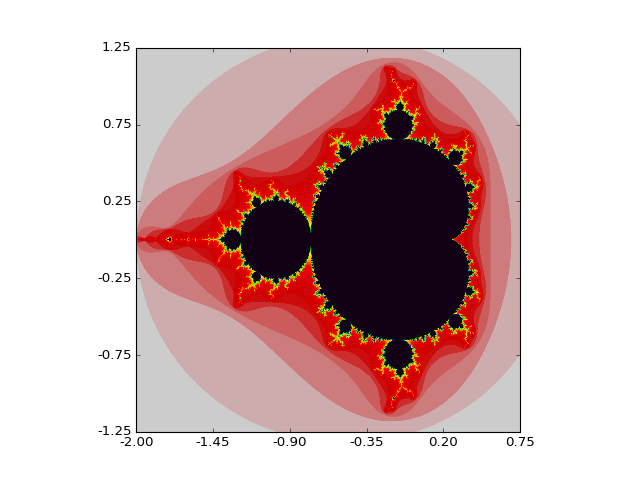

In [7]:
escImgParam(fn=lambda x,c: x*x + c, xmin=-2, xmax=.75, ymin=-1.25,
            ymax=1.25, colorMap="spectral") 

<h1><center>How to Make the Mandelbrot Set</center></h1>
- The Mandelbrot Set is a Parameter Space Escape Image for the map <center>$f_c(z) = z^2 + c$</center>
such that $f : \mathbb{C} \rightarrow \mathbb{C}$
- "Parameter Space" means that each pixel is representing a value for the parameter $c \in \mathbb{C}$
- So what we need to do is to iterate the map $f_c(0)$ some number of times for each pixel (value for $c$) in our plane and determine how "fast" that point escapes
- We then color that pixel with the relative amount of time it took for that point to escape
    - We iterate on the value 0 for technical reasons (it's special)
    - In this case, "escape" means $|f^n_c(0)| > 2$


<h1><center>How to Make the Mandelbrot Set Contd.</center></h1>
- Here is a very rough paritioning of the complex plane
<center><img src="figs/partitions.svg" width="750" height="750" /></center>

<h1><center>How to Make the Mandelbrot Set Contd.</center></h1>
- Now we perform 100 iterations and color each "pixel" with how many iterations it took to get beyond a radius of 2
<center><img src="figs/100_iters.svg" width="750" height="750" /></center>

- For this talk I am just using a spectral colormap
<br>
<center><img src="figs/colormap_iters.svg" width="750" height="50" /></center>

<IPython.core.display.Javascript object>


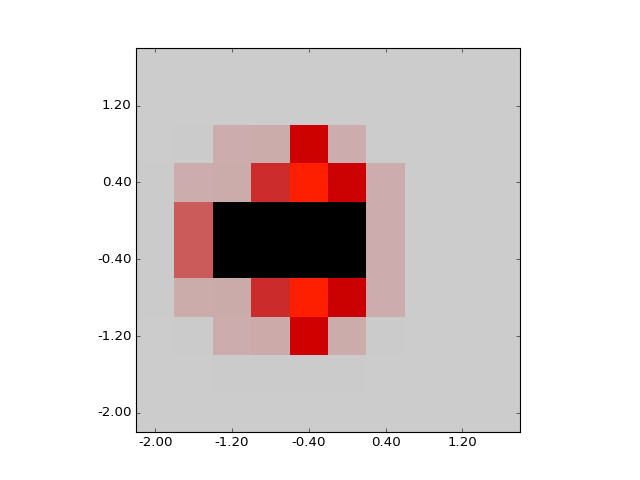

In [47]:
escImgParam(fn=lambda x,c: x*x + c, n=10, m=10, interp="none") 

<h1><center>Quick Numpy Intro</center></h1>
- Numpy is a versatile vector library, has lots of cool features:

In [83]:
ex = np.array([1,2,3,4])

# element-wise adition
print(ex + 2)
# vector ops
print(ex * ex)

[3 4 5 6]
[ 1  4  9 16]


In [84]:
# logical indexing
print(ex > 2)
print(ex)
print(ex[ex > 2])

[False False  True  True]
[1 2 3 4]
[3 4]


In [86]:
# Same as the following list comprehension:
def myLog(x, mask):
    return [x_i[0] for x_i in zip(x, mask) if x_i[1]]

print(myLog(ex, ex > 2))

[3, 4]


<h1><center>How to Make the Mandelbrot Set</center></h1>
- So lets walk though the computation of a $5 \times 5$ image
- Credit for Numpy approach: [Dan Goodman](https://thesamovar.wordpress.com/2009/03/22/fast-fractals-with-python-and-numpy/)

In [117]:
# Set all of the initial variables
fn = lambda x,c: x*x + c
critPoint = 0
escapeRad = 2.0
n = 5
m = 5
itermax = 100
xmin = -2
xmax = 2
ymin = -2
ymax = 2

In [125]:
# makes an n*m grid of integers (for indexing)
ix, iy = np.mgrid[0:n, 0:m]

# n evenly spaced points between xmin and xmax
x = np.linspace(xmin, xmax, n)[ix]
y = np.linspace(ymin, ymax, m)[iy]

c = x + complex(0, 1) * y
del x, y  # save a bit of memory, we only need z

# Now lets look inside c:
print(c[0,0])
print(c[1,1])
print(c[2,2])
print(c[3,3])
print(c[4,4])

(-2-2j)
(-1-1j)
0j
(1+1j)
(2+2j)


In [126]:
# Create array of critical points (in this case 0)
img = np.zeros(c.shape, dtype=int)

# Now we flatten these maps
ix.shape = n * m
iy.shape = n * m
c.shape = n * m

# Check contents of c
print(c)

[-2.-2.j -2.-1.j -2.+0.j -2.+1.j -2.+2.j -1.-2.j -1.-1.j -1.+0.j -1.+1.j
 -1.+2.j  0.-2.j  0.-1.j  0.+0.j  0.+1.j  0.+2.j  1.-2.j  1.-1.j  1.+0.j
  1.+1.j  1.+2.j  2.-2.j  2.-1.j  2.+0.j  2.+1.j  2.+2.j]


In [127]:
# Now apply our function (f_c) to all of the points in c
z = fn(critPoint, np.copy(c))

for i in range(itermax):

    # If there aren't any values left, stop iterating
    if not len(z):
        break  # all points have escaped

    # Perform an iteration of our map
    z = fn(z, c)

    # A logical vector specifying the points which have escaped
    rem = abs(z) > escapeRad

    # Store the iteration, i, at which the rem points escaped
    img[ix[rem], iy[rem]] = i + 1

    # Now rem represents the points which have remained bounded
    rem = ~rem

    # Filter out all escaped values
    z, ix, iy, c = z[rem], ix[rem], iy[rem], c[rem]

# sets those points which have not yet escaped to itermax + 1 (which is to say that these points took the longest
#  to escape, or didn't)
img[img == 0] = itermax + 1

In [128]:
print(img.T)

[[  1   1   1   1   1]
 [  1   2 101   1   1]
 [101 101 101   2   1]
 [  1   2 101   1   1]
 [  1   1   1   1   1]]


<IPython.core.display.Javascript object>


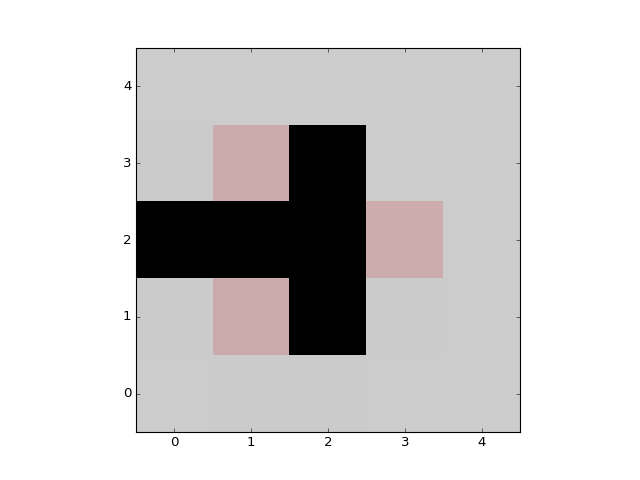

In [135]:
# Reverses the colormap for aesthetic reasons
img = abs(itermax - img)

# create a new figure
fig = plt.figure()

# make an image of the 
image = plt.imshow(img.T, origin='lower left', interpolation="none")
image.set_cmap("nipy_spectral")

<IPython.core.display.Javascript object>


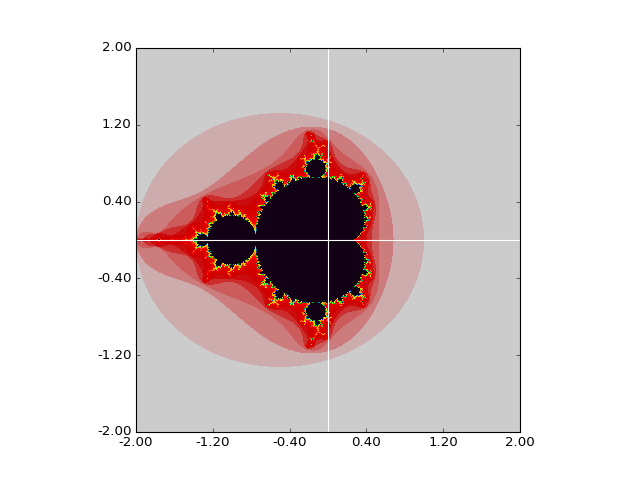

In [143]:
# Now we can make the image higher resolution and we get the image we expect
escImgParam(fn = lambda x,c: x*x + c, n=5000, m=5000, showAxes=True)

# Julia Set
Phase Space escape image for $x \mapsto x^2 - 1$

In [ ]:
escImgPhase(fn=lambda x: x*x - 1, n=1000, m=1000, colorMap=favColorMap)

# Mandelbrot Set
Parameter space image for the map $x \mapsto x^2 + c$

In [ ]:
escImgParam(n=1000, m=1000, xmin=-2, xmax=.75, ymin=-1.25,
            ymax=1.25, colorMap=favColorMap)

# Burning Ship Fractal
Parameter space image for the map $\displaystyle z \mapsto \left(|\operatorname{Re}(z)|+i\left|\operatorname{Im}(z)\right|\right)^2 + c$

In [ ]:
def bShip(z,c): return (abs(np.real(z)) + abs(np.imag(z))*complex(0,1))**2 + c

In [ ]:
escImgParam("burning_ship2", fn=bShip, n=1000, m=1000, xmin=-2, xmax=1.25, ymin=-1.75, ymax=1.25, colorMap=favColorMap)